In [ ]:
# Download the Stanford Dogs Dataset
!pip install kaggle
%env KAGGLE_USERNAME=???
%env KAGGLE_KEY=???
!kaggle competitions download -c generative-dog-images
!unzip \*.zip
!rm generative-dog-images.zip
!unzip \*.zip
!rm *.zip
!mkdir cropped-dogs
!mkdir train
!mkdir val
!mkdir test

Streaming output truncated to the last 5000 lines.
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n02092339_284.jpg  
  inflating: all-dogs/n02093859_36.jpg  
  inflating: all-dogs/n02096294_2343.jpg  
  infl

In [ ]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import datetime
import cv2
import random
import xml.etree.ElementTree as ET
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from pathlib import Path
from tqdm import tqdm
from keras.layers import Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Layer
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
#tf.__version__

In [ ]:
# Set constants
imgWidth = 256
imgHeight = 256
imgChannels = 3
imgDir = 'all-dogs/'
cropDir = 'cropped-dogs/'
annDir = "Annotation/"
trainDir = "train/"
valDir = "val/"
testDir = "test/"

In [ ]:
# ORIGINAL
# Method to crop images and create new ones from bounding boxes
def cropImages():
    index = 0  # Index for cropped images
    filenames = []  # List to store filenames of cropped images
    breeds = []  # List to store corresponding dog breeds

    # Loop through each breed folder in the annotation directory
    for breedDir in os.listdir(annDir):
        # Loop through each annotation file in the breed folder
        for ann in tqdm(os.listdir(os.path.join(annDir, breedDir))):
            # Read the original image
            img = cv2.imread(os.path.join(imgDir, ann + '.jpg'))
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Parse the XML annotation file for bounding box information
            tree = ET.parse(os.path.join(annDir, breedDir, ann))
            root = tree.getroot()
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            dogs = root.findall('object')

            # Loop through each object (bounding box) in the annotation file
            for dog in dogs:
                bndbox = dog.find('bndbox')
                breed = dog.find('name').text

                # Extract bounding box coordinates
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Calculate the minimum dimension of the bounding box
                dmin = np.min((xmax - xmin, ymax - ymin))

                # Crop the image using the adjusted bounding box coordinates
                img_cropped = img[ymin:ymin + dmin, xmin:xmin + dmin, :]

                # Determine the interpolation method based on the resizing operation
                if xmax - xmin > imgWidth:
                    interpolation = cv2.INTER_AREA  # Shrink
                else:
                    interpolation = cv2.INTER_CUBIC  # Expand

                # Resize the cropped image to the desired dimensions
                img_cropped = cv2.resize(img_cropped, (imgWidth, imgHeight), interpolation=interpolation)

                # Save the cropped image with a new filename
                filename = str(index) + '.jpg'
                cv2.imwrite(os.path.join(cropDir, filename), img_cropped)

                # Update lists with filename and breedname
                filenames.append(filename)
                breeds.append(breed)

                # Increment the index
                index += 1

    return filenames, breeds

In [ ]:
# FULL BOUNDING BOX ON A BLACK SQUARE NOT TO LOSE A PORTION OF A DOG
"""
def cropFullImages():
    index = 0  # Index for cropped images
    filenames = []  # List to store filenames of cropped images
    breeds = []  # List to store corresponding dog breeds

    # Loop through each breed folder in the annotation directory
    for breedDir in os.listdir(annDir):
        # Loop through each annotation file in the breed folder
        for ann in tqdm(os.listdir(os.path.join(annDir, breedDir))):
            # Read the original image
            img = cv2.imread(os.path.join(imgDir, ann + '.jpg'))
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Parse the XML annotation file for bounding box information
            tree = ET.parse(os.path.join(annDir, breedDir, ann))
            root = tree.getroot()
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            dogs = root.findall('object')

            # Loop through each object (bounding box) in the annotation file
            for dog in dogs:
                bndbox = dog.find('bndbox')
                breed = dog.find('name').text

                # Extract bounding box coordinates
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Calculate the maximum dimension of the bounding box
                if xmin < 0:
                    xmin = 0
                if ymin < 0:
                    ymin = 0
                if xmax > width:
                    xmax = width
                if ymax > height:
                    ymax = height
                xlen = xmax - xmin
                ylen = ymax - ymin
                dmax = max(xlen, ylen)
                img_cropped = np.zeros((dmax, dmax, 3))
                xstart = int((dmax - xlen) / 2)
                ystart = int((dmax - ylen) / 2)

                #(286,408,3) into shape (286,419,3)
                #if ylen==286 and xlen==419:
                    #print(ann,xmin,xmax,ymin,ymax,xlen,ylen,dmax,xstart,ystart)
                    #92 511 42 328 419 286 419 0 66
                #else:
                    #continue

                # Crop the image using the adjusted bounding box coordinates
                img_cropped[ystart:ystart+ylen, xstart:xstart+xlen, :] = img[ymin:ymax, xmin:xmax, :]

                # Determine the interpolation method based on the resizing operation
                if dmax > imgWidth:
                    interpolation = cv2.INTER_AREA  # Shrink
                else:
                    interpolation = cv2.INTER_CUBIC  # Expand

                # Resize the cropped image to the desired dimensions
                img_cropped = cv2.resize(img_cropped, (imgWidth, imgHeight), interpolation=interpolation)

                # Save the cropped image with a new filename
                filename = str(index) + '.jpg'
                cv2.imwrite(os.path.join(cropDir, filename), img_cropped)

                # Update lists with filename and breedname
                filenames.append(filename)
                breeds.append(breed)

                # Increment the index
                index += 1

    return filenames, breeds
"""

"\ndef cropFullImages():\n    index = 0  # Index for cropped images\n    filenames = []  # List to store filenames of cropped images\n    breeds = []  # List to store corresponding dog breeds\n\n    # Loop through each breed folder in the annotation directory\n    for breedDir in os.listdir(annDir):\n        # Loop through each annotation file in the breed folder\n        for ann in tqdm(os.listdir(os.path.join(annDir, breedDir))):\n            # Read the original image\n            img = cv2.imread(os.path.join(imgDir, ann + '.jpg'))\n            if img is None:\n                continue\n            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n            # Parse the XML annotation file for bounding box information\n            tree = ET.parse(os.path.join(annDir, breedDir, ann))\n            root = tree.getroot()\n            size = root.find('size')\n            width = int(size.find('width').text)\n            height = int(size.find('height').text)\n            dogs = root.findal

In [ ]:
# Crop images
startTime = time.time()
filenames, breeds = cropImages()
duration = round(time.time() - startTime)
print("\nCrop time: {}.".format(str(datetime.timedelta(seconds=duration))))

100%|██████████| 155/155 [00:00<00:00, 158.63it/s]


Crop time: 0:02:34.


In [ ]:
print('Original images:', len(os.listdir(imgDir)))
print('Cropped images:', len(os.listdir(cropDir)))
print('Filenames:', len(filenames))
print('Labels:', len(breeds))

Original images: 20579
Cropped images: 22125
Filenames: 22125
Labels: 22125


In [ ]:
# Create a data frame with filenames and breeds (labels)
df = pd.DataFrame({'filename': filenames, 'label': breeds})
df

filename               label
0          0.jpg               Lhasa
1          1.jpg               Lhasa
2          2.jpg               Lhasa
3          3.jpg               Lhasa
4          4.jpg               Lhasa
...          ...                 ...
22120  22120.jpg  standard_schnauzer
22121  22121.jpg  standard_schnauzer
22122  22122.jpg  standard_schnauzer
22123  22123.jpg  standard_schnauzer
22124  22124.jpg  standard_schnauzer

[22125 rows x 2 columns]

In [ ]:
# Create an image data generator with normalization
dataGen = ImageDataGenerator(rescale = 1/255.)

In [ ]:
# Run this when there is no initial training or fine-tuning
"""
generator = dataGen.flow_from_dataframe(
    dataframe = df,
    directory = cropDir,
    target_size = (imgWidth, imgHeight),
    x_col = 'filename',
    class_mode = None,
    batch_size = 32,
    shuffle = False,
    classes= None)
"""

"\ngenerator = dataGen.flow_from_dataframe(\n    dataframe = df,\n    directory = cropDir,\n    target_size = (imgWidth, imgHeight),\n    x_col = 'filename',\n    class_mode = None,\n    batch_size = 32,\n    shuffle = False,\n    classes= None)\n"

In [ ]:
# Move all files back to croppped-dogs to test with another random distribution
"""
trainfiles = glob.glob(trainDir + '*.*')
for trainfile in trainfiles:
    shutil.move(trainfile, trainfile.replace(trainDir, cropDir))
valfiles = glob.glob(valDir + '*.*')
for valfile in valfiles:
    shutil.move(valfile, valfile.replace(valDir, cropDir))
testfiles = glob.glob(testDir + '*.*')
for testfile in testfiles:
    shutil.move(testfile, testfile.replace(testDir, cropDir))

print(len(glob.glob(cropDir + '*.*')))
print(len(glob.glob('train/*.*')))
print(len(glob.glob('val/*.*')))
print(len(glob.glob('test/*.*')))
"""

"\ntrainfiles = glob.glob(trainDir + '*.*')\nfor trainfile in trainfiles:\n    shutil.move(trainfile, trainfile.replace(trainDir, cropDir))\nvalfiles = glob.glob(valDir + '*.*')\nfor valfile in valfiles:\n    shutil.move(valfile, valfile.replace(valDir, cropDir))\ntestfiles = glob.glob(testDir + '*.*')\nfor testfile in testfiles:\n    shutil.move(testfile, testfile.replace(testDir, cropDir))\n\nprint(len(glob.glob(cropDir + '*.*')))\nprint(len(glob.glob('train/*.*')))\nprint(len(glob.glob('val/*.*')))\nprint(len(glob.glob('test/*.*')))\n"

In [ ]:
# Distribute cropped dog files into train, val, and test randomly (80:10:10)
import shutil
import glob

# Set the number of files to go into val and test directories
testCount = 2212 # 10% of 22125

# Set random seed to generate same results
random.seed(1)

# Randomly move files into the val directory
valfiles = np.random.choice(glob.glob(cropDir + '*.*'), size=testCount, replace=False)
for valfile in valfiles:
    shutil.move(valfile, valfile.replace(cropDir, valDir))

# Randomly move files into the test directory
testfiles = np.random.choice(glob.glob(cropDir + '*.*'), size=testCount, replace=False)
for testfile in testfiles:
    shutil.move(testfile, testfile.replace(cropDir, testDir))

# Move the remaining files into the train directory
trainfiles = glob.glob(cropDir + '*.*')
for trainfile in trainfiles:
    shutil.move(trainfile, trainfile.replace(cropDir, trainDir))

print(len(glob.glob(cropDir + '*.*')))
print(len(glob.glob('train/*.*')))
print(len(glob.glob('val/*.*')))
print(len(glob.glob('test/*.*')))

0
17701
2212
2212


In [ ]:
# Method to create data frames for train, val, and test files
def createDataFrame(dir):
    filenames = []  # List to store filenames
    labels = []  # List to store labels

    # Loop through directory
    for filename in os.listdir(dir):
        # Update lists with filename and label
        filenames.append(filename)
        label = df.loc[df['filename'] == filename, 'label'].iloc[0]
        labels.append(label)

    return pd.DataFrame({'filename': filenames, 'label': labels})

In [ ]:
# Create data frames
trainDF = createDataFrame(trainDir)
valDF = createDataFrame(valDir)
testDF = createDataFrame(testDir)

In [ ]:
# Use the pre-trained Xception model from https://keras.io/api/applications/
"""
from keras.applications import Xception

baseModel = Xception(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))

for layer in baseModel.layers:
    layer.trainable = False

inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)
output= GlobalAveragePooling2D()(x)

model = Model(inputs = inputLayer, outputs= output)
model.summary()
"""

'\nfrom keras.applications import Xception\n\nbaseModel = Xception(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))\n\nfor layer in baseModel.layers:\n    layer.trainable = False\n\ninputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))\nx = baseModel(inputLayer)\noutput= GlobalAveragePooling2D()(x)\n\nmodel = Model(inputs = inputLayer, outputs= output)\nmodel.summary()\n'

In [ ]:
# Use the pre-trained VGG16 model from https://keras.io/api/applications/
"""
from keras.applications import VGG16

baseModel = VGG16(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))

for layer in baseModel.layers:
    layer.trainable = False

inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)
output= GlobalAveragePooling2D()(x)

model = Model(inputs = inputLayer, outputs= output)
model.summary()
"""

'\nfrom keras.applications import VGG16\n\nbaseModel = VGG16(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))\n\nfor layer in baseModel.layers:\n    layer.trainable = False\n\ninputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))\nx = baseModel(inputLayer)\noutput= GlobalAveragePooling2D()(x)\n\nmodel = Model(inputs = inputLayer, outputs= output)\nmodel.summary()\n'

In [ ]:
# Use the pre-trained ResNet50V2 model from https://keras.io/api/applications/
"""
from keras.applications import ResNet50V2

baseModel = ResNet50V2(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))

for layer in baseModel.layers:
    layer.trainable = False

inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)
output= GlobalAveragePooling2D()(x)

model = Model(inputs = inputLayer, outputs= output)
model.summary()
"""

'\nfrom keras.applications import ResNet50V2\n\nbaseModel = ResNet50V2(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))\n\nfor layer in baseModel.layers:\n    layer.trainable = False\n\ninputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))\nx = baseModel(inputLayer)\noutput= GlobalAveragePooling2D()(x)\n\nmodel = Model(inputs = inputLayer, outputs= output)\nmodel.summary()\n'

In [ ]:
# Use the pre-trained EfficientNetV2M model from https://keras.io/api/applications/
"""
from keras.applications import EfficientNetV2M

baseModel = EfficientNetV2M(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))

for layer in baseModel.layers:
    layer.trainable = False

inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)
output= GlobalAveragePooling2D()(x)

model = Model(inputs = inputLayer, outputs= output)
model.summary()
"""

'\nfrom keras.applications import EfficientNetV2M\n\nbaseModel = EfficientNetV2M(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))\n\nfor layer in baseModel.layers:\n    layer.trainable = False\n\ninputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))\nx = baseModel(inputLayer)\noutput= GlobalAveragePooling2D()(x)\n\nmodel = Model(inputs = inputLayer, outputs= output)\nmodel.summary()\n'

In [ ]:
# Use the pre-trained InceptionResNetV2 model from https://keras.io/api/applications/
"""
from keras.applications import InceptionResNetV2

baseModel = InceptionResNetV2(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))

for layer in baseModel.layers:
    layer.trainable = False

inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)
output= GlobalAveragePooling2D()(x)

model = Model(inputs = inputLayer, outputs= output)
model.summary()
"""

'\nfrom keras.applications import InceptionResNetV2\n\nbaseModel = InceptionResNetV2(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))\n\nfor layer in baseModel.layers:\n    layer.trainable = False\n\ninputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))\nx = baseModel(inputLayer)\noutput= GlobalAveragePooling2D()(x)\n\nmodel = Model(inputs = inputLayer, outputs= output)\nmodel.summary()\n'

In [ ]:
# Use the pre-trained ConvNeXtBase model from https://keras.io/api/applications/
"""
from keras.applications import ConvNeXtBase

baseModel = ConvNeXtBase(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))

for layer in baseModel.layers:
    layer.trainable = False

inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)
output= GlobalAveragePooling2D()(x)

model = Model(inputs = inputLayer, outputs= output)
model.summary()
"""

'\nfrom keras.applications import ConvNeXtBase\n\nbaseModel = ConvNeXtBase(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))\n\nfor layer in baseModel.layers:\n    layer.trainable = False\n\ninputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))\nx = baseModel(inputLayer)\noutput= GlobalAveragePooling2D()(x)\n\nmodel = Model(inputs = inputLayer, outputs= output)\nmodel.summary()\n'

In [ ]:
# Use the pre-trained DenseNet201 model from https://keras.io/api/applications/
"""
from keras.applications import DenseNet201

baseModel = DenseNet201(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))

for layer in baseModel.layers:
    layer.trainable = False

inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)
output= GlobalAveragePooling2D()(x)

model = Model(inputs = inputLayer, outputs= output)
model.summary()
"""

'\nfrom keras.applications import DenseNet201\n\nbaseModel = DenseNet201(include_top = False, input_shape= (imgWidth, imgHeight, imgChannels))\n\nfor layer in baseModel.layers:\n    layer.trainable = False\n\ninputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))\nx = baseModel(inputLayer)\noutput= GlobalAveragePooling2D()(x)\n\nmodel = Model(inputs = inputLayer, outputs= output)\nmodel.summary()\n'

In [ ]:
# Use the pre-trained NASNetLarge model from https://keras.io/api/applications/
from keras.applications import NASNetLarge

baseModel = NASNetLarge(include_top=False, input_shape=(imgWidth, imgHeight, imgChannels))

for layer in baseModel.layers:
    layer.trainable = False

inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)
output= GlobalAveragePooling2D()(x)

model = Model(inputs = inputLayer, outputs= output)
model.summary()

343610240/343610240 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 8, 8, 4032)        84916818  
                                                                 
 global_average_pooling2d (  (None, 4032)              0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 84916818 (323.93 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 84916818 (323.93 MB)
_________________________________________________________________


In [ ]:
# Methods to calculate the top-1 and top-5 accuracy with the test data
def checkMatches(index):
    top1 = 0
    top5 = 0
    dist, simIndex = nearestNeighbors.kneighbors(X=X[index,:].reshape(1,-1))
    breed = testDF.loc[index,'label']
    for i in range(1, 6):
        similarBreed = testDF.loc[simIndex[0][i],'label']
        if breed == similarBreed:
            if i == 1:
                top1 = 1
            top5 = 1
            break
    return top1, top5

def calculateAccuracy():
    totalTop1 = 0
    totalTop5 = 0
    size = len(testDF)
    for i in range(size):
        top1, top5 = checkMatches(i)
        totalTop1 += top1
        totalTop5 += top5
    top1Acc = totalTop1 / (size * 1.0)
    top5Acc = totalTop5 / (size * 1.0)
    print(top1Acc, top5Acc)

In [ ]:
# Test data generator
testGen = dataGen.flow_from_dataframe(
    dataframe = testDF,
    directory = testDir,
    target_size = (imgWidth, imgHeight),
    x_col = 'filename',
    class_mode = None,
    batch_size = 32,
    shuffle=False,
    classes= None)

# Calculate the top-1 and top-5 accuracy without any initial training or fine-tuning
X = model.predict(testGen, verbose=1)
y = testDF['label']
nearestNeighbors = KNeighborsClassifier(n_neighbors = 6)
nearestNeighbors.fit(X, y)
calculateAccuracy()

Found 2212 validated image filenames.
70/70 [==============================] - 44s 420ms/step
0.7396021699819169 0.895117540687161


In [ ]:
# Initial Training Phase (with all base model layers frozen)

# Set the number of classes
numClasses = 120

# Load the base model, without the top layers
baseModel = NASNetLarge(include_top=False, input_shape=(imgWidth, imgHeight, imgChannels))

# Freeze the layers of the base model
for layer in baseModel.layers:
    layer.trainable = False

# Create the input layer and pass it through the base model
inputLayer = Input(shape=(imgWidth, imgHeight, imgChannels))
x = baseModel(inputLayer)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(256, activation='relu')(x)

# Add the final softmax layer for classification
output = Dense(numClasses, activation='softmax')(x)

# Construct the final model
model = Model(inputs=inputLayer, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 8, 8, 4032)        84916818  
                                                                 
 global_average_pooling2d_1  (None, 4032)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 256)               1032448   
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
Total params: 85980106 (327.99 MB)
Trainable params: 1063288 (4.06 MB)
Non-trainable params: 84916818 (323.93 MB)
___________

In [ ]:
# Initial training

# Training data generator
trainGen = dataGen.flow_from_dataframe(
    dataframe = trainDF,
    directory = trainDir,
    target_size = (imgWidth, imgHeight),
    x_col = 'filename',
    y_col = 'label',
    batch_size = 32,
    shuffle=True,
    class_mode='categorical')

# Validation data generator
valGen = dataGen.flow_from_dataframe(
    dataframe = valDF,
    directory = valDir,
    target_size = (imgWidth, imgHeight),
    x_col = 'filename',
    y_col = 'label',
    batch_size = 32,
    shuffle=True,
    class_mode='categorical')

# Number of epochs for initial training
initialTrainEpochs = 5

# Initial training with frozen base model layers
history = model.fit(
    trainGen, # training data
    epochs=initialTrainEpochs, # number of epochs
    validation_data=valGen # validation data
)

Found 17701 validated image filenames belonging to 120 classes.
Found 2212 validated image filenames belonging to 120 classes.
Epoch 1/5
554/554 [==============================] - 321s 547ms/step - loss: 1.4735 - accuracy: 0.7046 - val_loss: 0.6709 - val_accuracy: 0.8160
Epoch 2/5
554/554 [==============================] - 297s 537ms/step - loss: 0.6322 - accuracy: 0.8183 - val_loss: 0.6105 - val_accuracy: 0.8232
Epoch 3/5
554/554 [==============================] - 297s 535ms/step - loss: 0.5390 - accuracy: 0.8399 - val_loss: 0.5931 - val_accuracy: 0.8264
Epoch 4/5
554/554 [==============================] - 297s 535ms/step - loss: 0.4752 - accuracy: 0.8563 - val_loss: 0.5803 - val_accuracy: 0.8232
Epoch 5/5
554/554 [==============================] - 297s 536ms/step - loss: 0.4216 - accuracy: 0.8709 - val_loss: 0.5797 - val_accuracy: 0.8192


In [ ]:
# Calculate the top-1 and top-5 accuracy after initial training
X = model.predict(testGen, verbose=1)
y = testDF['label']
nearestNeighbors = KNeighborsClassifier(n_neighbors = 6)
nearestNeighbors.fit(X, y)
calculateAccuracy()

70/70 [==============================] - 38s 469ms/step
0.7798372513562387 0.8847197106690777


In [ ]:
# Fine-Tuning Phase (unfreeze some top layers of the base model):

# Unfreeze the top layers of the model
baseModel.trainable = True

# NASNetLarge has 533 layers
# Start by unfreezing the top 10-20% of the layers
# Decide how many layers you want to unfreeze
fineTuneAt = 480  # Adjust this number based on your specific model

# Freeze all the layers before the 'fine_tune_at' layer
for layer in baseModel.layers[:fineTuneAt]:
    layer.trainable =  False

# Recompile the model (necessary for these changes to take effect)
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 8, 8, 4032)        84916818  
                                                                 
 global_average_pooling2d_1  (None, 4032)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 256)               1032448   
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
Total params: 85980106 (327.99 MB)
Trainable params: 78173272 (298.21 MB)
Non-trainable params: 7806834 (29.78 MB)
__________

In [ ]:
# Fine-tuning

# Number of epochs for fine-tuning
fineTuneEpochs = 2

# Train the model
history = model.fit(
    trainGen, # training data
    epochs=fineTuneEpochs, # number of epochs
    validation_data=valGen # validation data
)

Epoch 1/2
554/554 [==============================] - 707s 1s/step - loss: 0.5100 - accuracy: 0.8467 - val_loss: 0.5234 - val_accuracy: 0.8418
Epoch 2/2
554/554 [==============================] - 597s 1s/step - loss: 0.2604 - accuracy: 0.9215 - val_loss: 0.4874 - val_accuracy: 0.8522


In [ ]:
# Calculate the top-1 and top-5 accuracy after fine-tuning
X = model.predict(testGen, verbose=1)
y = testDF['label']
nearestNeighbors = KNeighborsClassifier(n_neighbors = 6)
nearestNeighbors.fit(X, y)
calculateAccuracy()
# random seed: 1
# transfer model: 0.74 0.90
# initial training: 0.78 0.88
# fine-tuning: 0.82 0.90

70/70 [==============================] - 38s 471ms/step
0.8150994575045208 0.8996383363471971


In [ ]:
#model.save('model.keras')

In [ ]:
#from keras.models import load_model
#model = load_model('model.keras')

In [ ]:
# run this when there is no initial training or fine-tuning
# X = model.predict(generator, verbose=1)
# y = df['label']

In [ ]:
#np.save('X.npy', X)

In [ ]:
#X = np.load('X.npy')

In [ ]:
print(X.shape)
print(y.shape)

(2212, 120)
(2212,)


In [ ]:
print(X[0,:])
print(y[0])

[2.63708280e-05 1.45418494e-06 2.32777211e-07 3.12856230e-07
 6.05913613e-07 3.91716782e-07 2.28959811e-06 4.71405583e-05
 9.42441184e-05 8.91363413e-07 6.31785997e-06 1.96884480e-06
 2.37317067e-06 1.89643913e-06 3.54953336e-05 1.41262819e-06
 1.46898856e-05 1.66729171e-06 5.26010581e-06 2.93741778e-07
 3.48519256e-06 1.09487242e-04 6.89000008e-05 2.09082555e-06
 3.11639360e-06 1.26914676e-06 6.81212811e-08 3.27909277e-07
 2.36755222e-05 4.41094744e-06 5.14127241e-05 4.06244851e-07
 7.36812922e-07 6.15459703e-06 1.18637599e-05 1.49410516e-05
 7.75093940e-06 2.74399054e-06 4.98721101e-06 3.50184109e-06
 1.08931445e-05 1.68210806e-06 6.32875381e-05 8.77301045e-06
 5.03295851e-05 1.07138703e-06 2.32269508e-06 8.74087050e-07
 6.35006199e-06 8.72157784e-07 2.47577600e-06 5.86254509e-06
 8.19892477e-07 1.24642236e-06 2.21431992e-06 5.78800098e-07
 2.00673585e-05 4.85203327e-06 3.79098019e-05 6.02600358e-06
 1.24899443e-05 3.34884135e-05 6.61173090e-07 3.74201613e-06
 5.53139362e-05 1.393269

In [ ]:
def readCroppedImg(filename):
    image = load_img(os.path.join(testDir, filename), target_size=(imgWidth, imgHeight, imgChannels))
    image = img_to_array(image)
    image = image / 255.
    return image

In [ ]:
def drawRandomBreed(df):
    plt.rcParams['font.size'] = 12

    i = random.randint(0, len(df))
    img1 = readCroppedImg(testDF.loc[i,'filename'])
    dist, index = nearestNeighbors.kneighbors(X=X[i,:].reshape(1,-1))
    plt.figure(figsize = (2 , 2))
    plt.imshow(img1)
    plt.title("Input Breed: \n" + df.loc[i,'label'])
    plt.axis('off')

    plt.figure(figsize = (20, 20))
    for i in range(1, 6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readCroppedImg(df.loc[index[0][i], 'filename'])
        plt.imshow(image)
        plt.title(f'Similar Breed #{i}: \n' + df.loc[index[0][i],'label'])
        plt.axis('off')

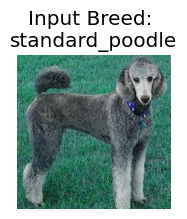

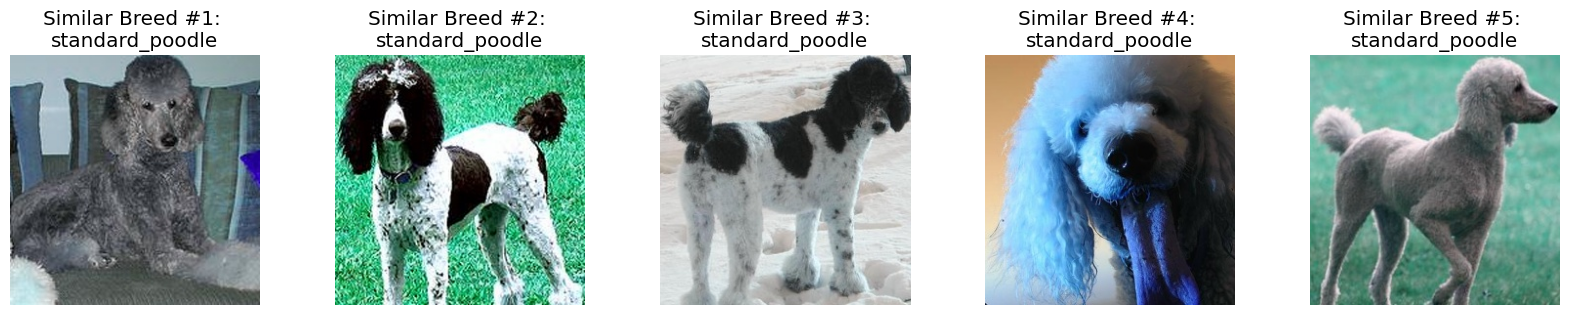

In [ ]:
drawRandomBreed(testDF)

In [ ]:
def uniqueList(df):
    return sorted(list(set(df['label'])))

In [ ]:
uniqueBreeds = uniqueList(testDF)
print(uniqueBreeds)

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

In [ ]:
len(uniqueBreeds)

120

In [ ]:
def findSimilarBreeds(df, breed):
    selectIndex = random.randint(0, 10)
    curIndex = 0
    count = len(df)
    for i in range(count):
        if df.loc[i,'label'] == breed:
          if curIndex != selectIndex:
              curIndex += 1
              continue
          img1 = readCroppedImg(df.loc[i,'filename'])
          dist, index = nearestNeighbors.kneighbors(X=X[i,:].reshape(1,-1))
          plt.figure(figsize = (2 , 2))
          plt.imshow(img1)
          plt.title("Input Breed: \n" + df.loc[i,'label'])
          plt.axis('off')
          break

    plt.figure(figsize = (20, 20))
    for i in range(1, 6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readCroppedImg(df.loc[index[0][i], 'filename'])
        plt.imshow(image)
        plt.title(f'Similar Breed #{i}: \n' + df.loc[index[0][i],'label'])
        plt.axis('off')

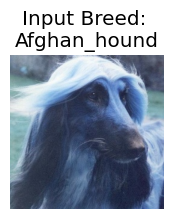

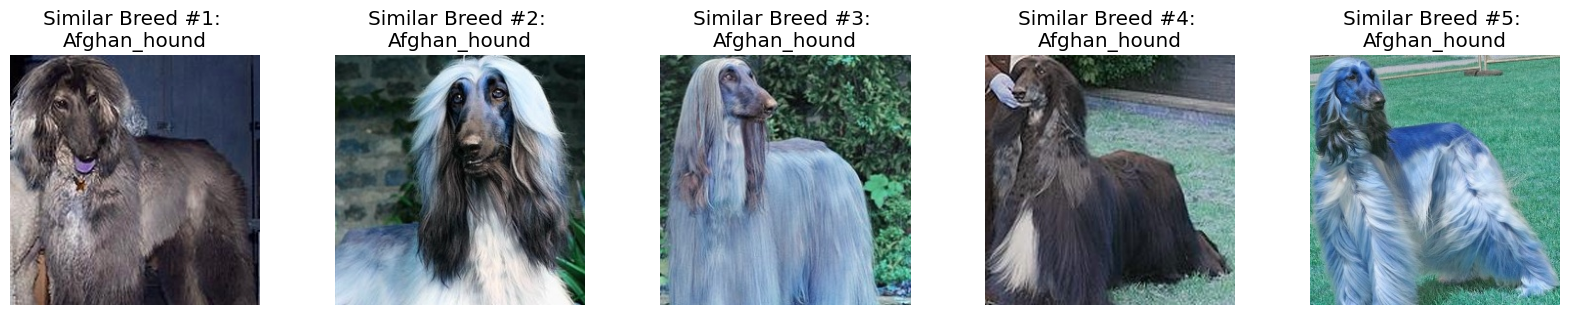

In [ ]:
findSimilarBreeds(testDF, 'Afghan_hound')

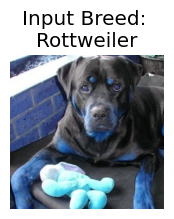

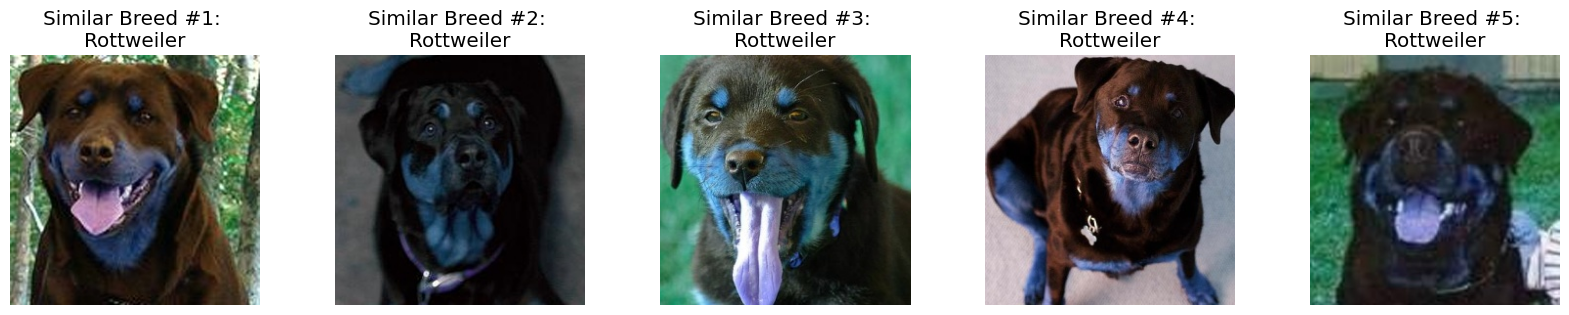

In [ ]:
findSimilarBreeds(testDF, 'Rottweiler')

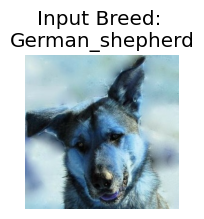

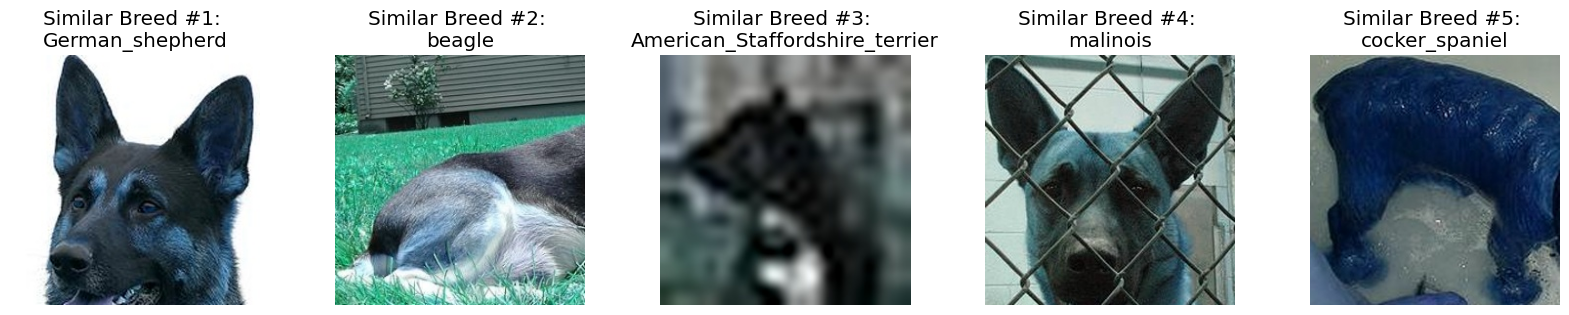

In [ ]:
findSimilarBreeds(testDF, 'German_shepherd')

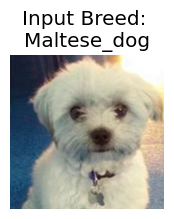

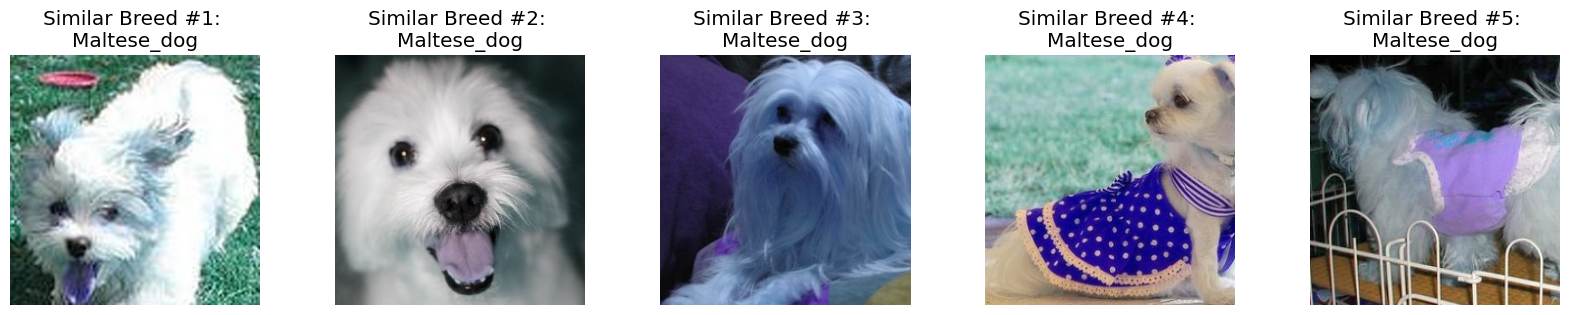

In [ ]:
findSimilarBreeds(testDF, 'Maltese_dog')

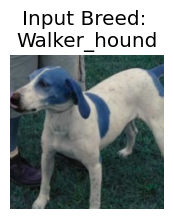

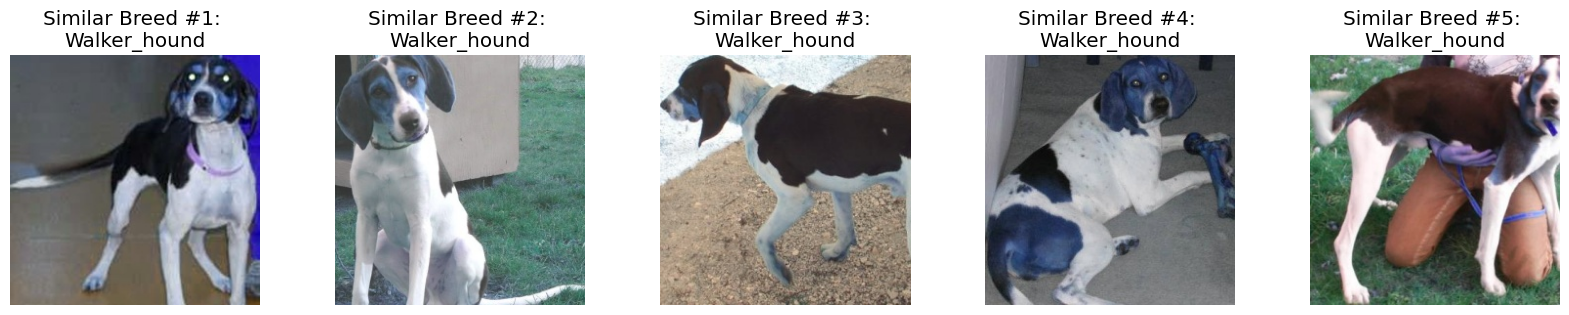

In [ ]:
breed = random.choice(uniqueBreeds)
findSimilarBreeds(testDF, breed)